In [1]:
import numpy as np
import matplotlib as mpl
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from numpy import asarray

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
import matplotlib.pyplot as plt

#thresholding
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

#felzenszwalb method
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.measure import label, regionprops

import matplotlib.patches as mpatches

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops#, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb

import csv
from matplotlib import cm


In [5]:
mpl.rcParams['figure.dpi'] = 300

# Image info - This section should be edited for each image

file_name = '5A'
crop_code = 1
plot_folder = 'cropped_images'

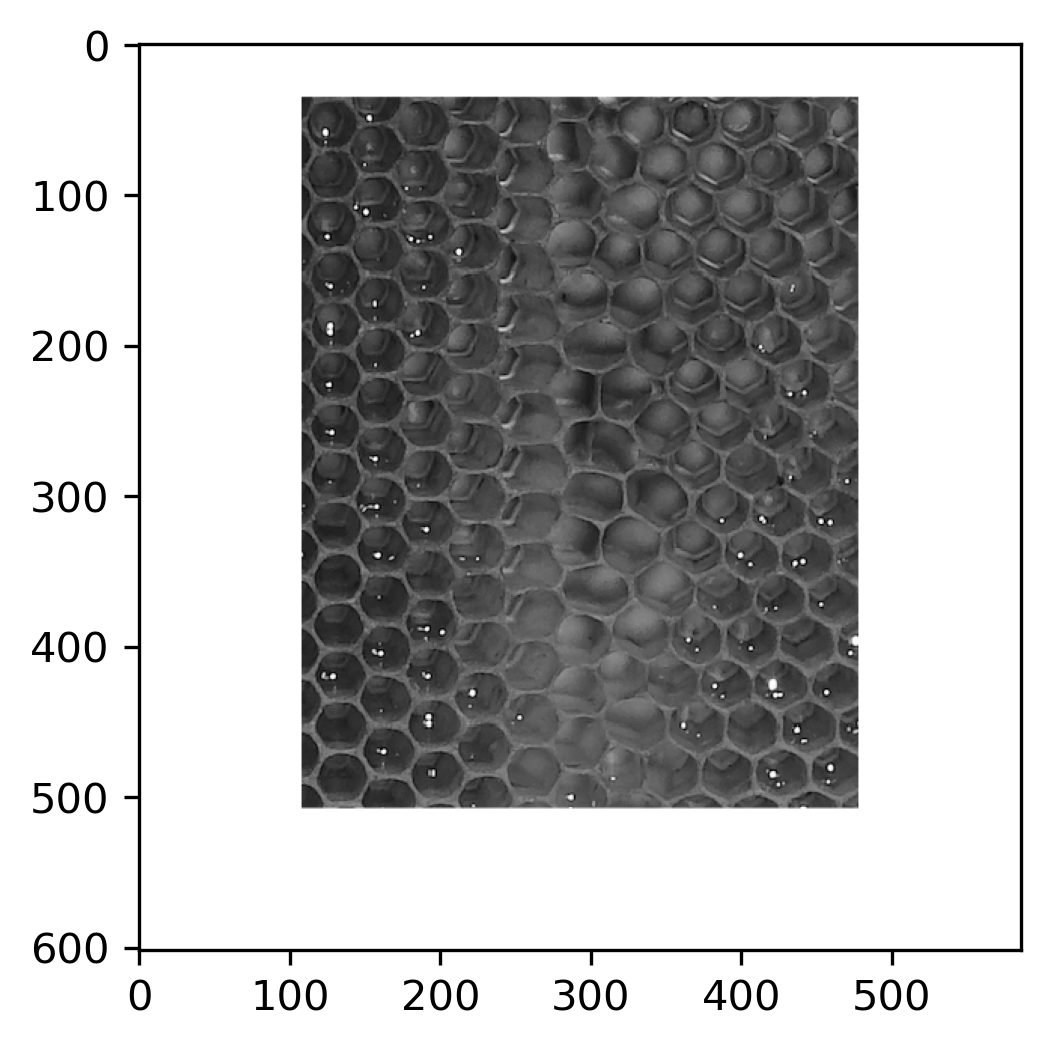

In [7]:
# Getting the original image

im1 = cv2.imread('{}/{}_crop{}.png'.format(plot_folder, file_name, crop_code), 0)
plt.imshow(im1, cmap = plt.cm.gray)

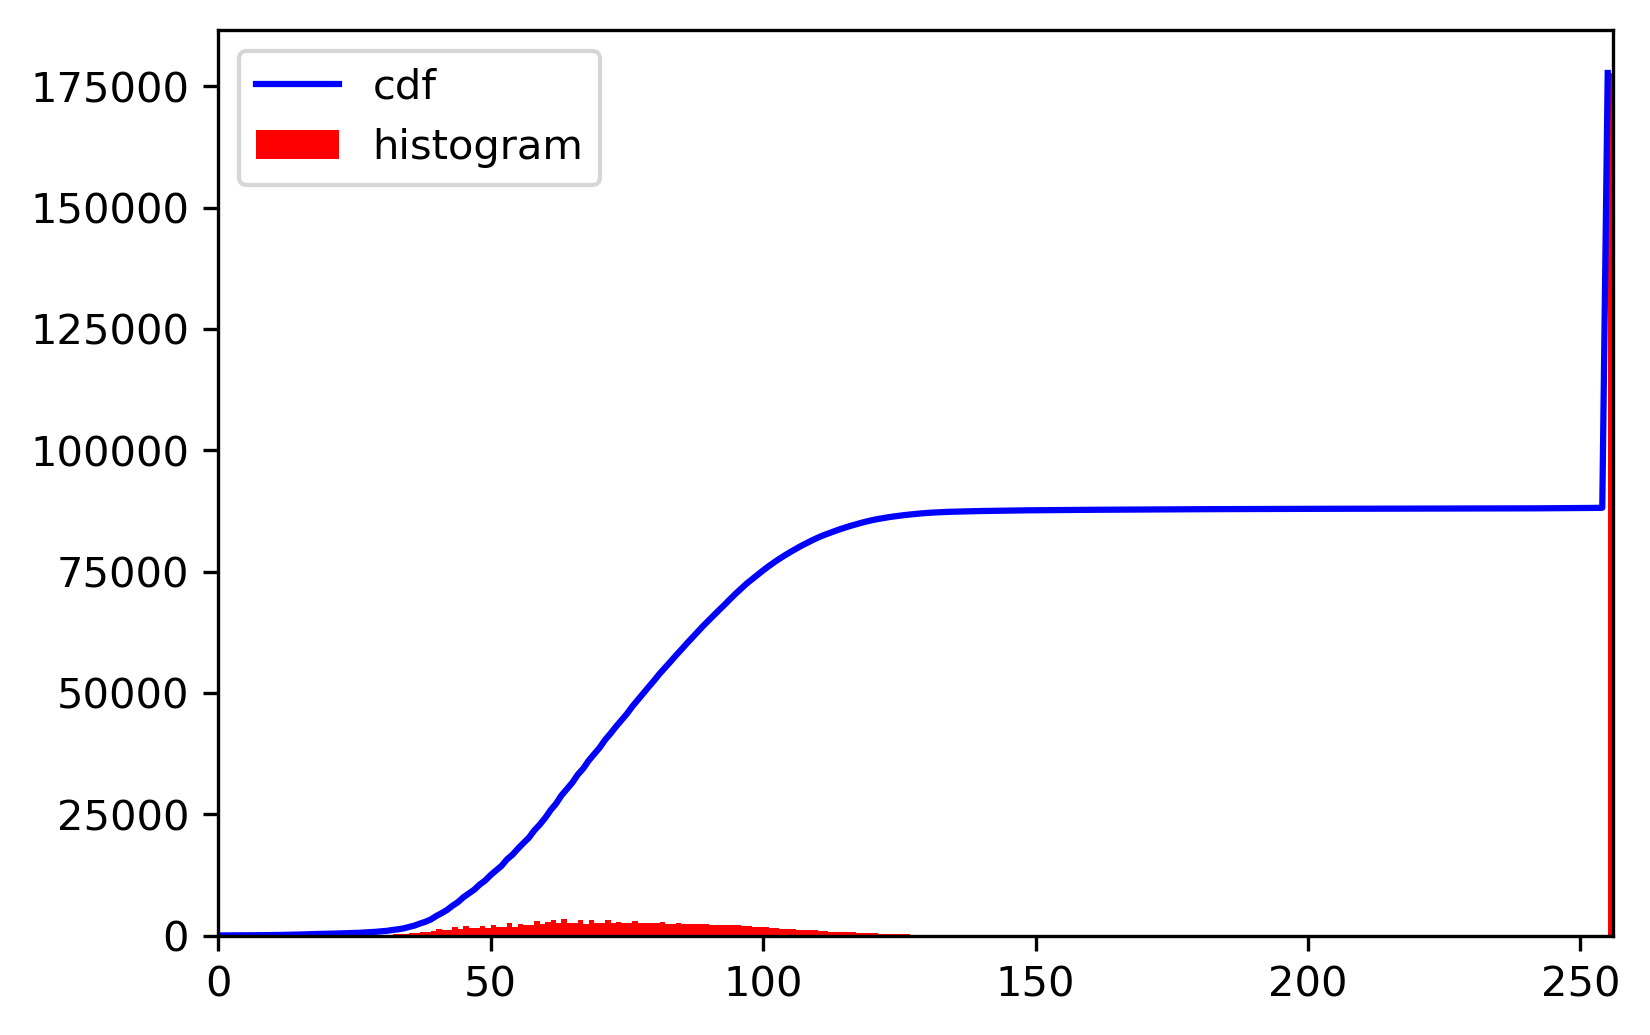

True

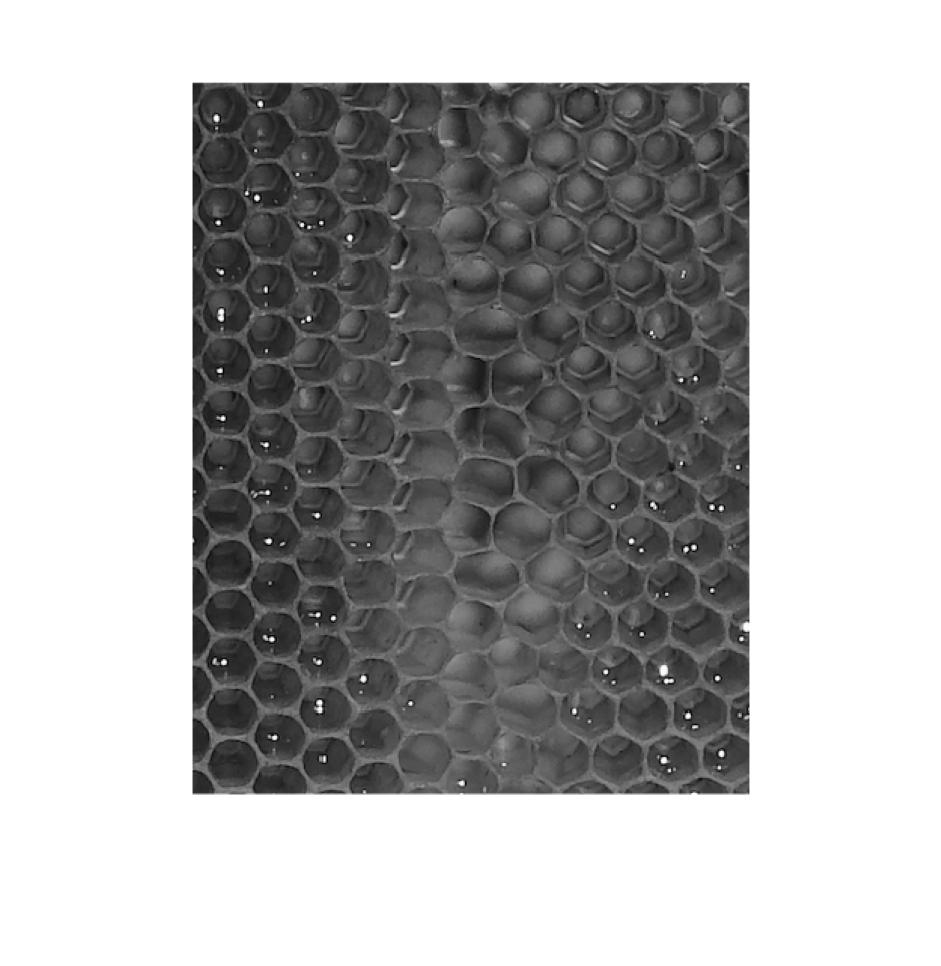

In [8]:
#Apply Histogram Equalization to the image

hist,bins = np.histogram(im1.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(im1.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()
plt.axis ('off')
plt.imshow(im1, cmap = plt.cm.gray)

#find minimum histogram value and apply histogram equalization
equ = cv2.equalizeHist(im1)
res = np.hstack((im1,equ)) #stacking images side-by-side
cv2.imwrite('{}/{}_crop{}_equalized.jpg'.format(plot_folder, file_name, crop_code), equ)

In [18]:
def find_components(img, lower_bound, upper_bound):
    
    """
    Finds connected components/regions is an image.

    Parameters
    ----------
    img : A crop of the desired frame
    lower_bound : smallest cell size that should be detected (should be in a floating point format)
    upper bound : largest cell size that should be detected (should be in a floating point format)

    Returns
    -------
    dim : Reduced image dimentions
    
    label_img: image with the regions detected
    
    images_label_overlay : colored labeled image with
        colors based on region size
        
    cell_positions_a : a list of coordiantes (y,x) 
        containing the centroids of each region.
        

    """
    img = (img[::2, ::2, :3])

    dim = img.shape
    print ('Image dimensions: ', dim)

    segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=100)

    gradient = sobel(rgb2gray(img))

    print ("Felzenszwalb number of segments:", len(np.unique(segments_fz)))

    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].imshow(mark_boundaries(img, segments_fz))
    ax[0, 0].set_title("After Felzenszwalbs's method")
    ax[0, 1].imshow(img)
    ax[0, 1].set_title('Original Image')

    for a in ax.ravel():
        a.set_axis_off()

    images = mark_boundaries(img, segments_fz)

    images = rgb2gray(images)#[50:-50, 50:-50]) 

    thresh = threshold_otsu(images)
    closed_img = closing(images > thresh, square(3))

    bw = 255 - closed_img 

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)

    #print(label_image.shape)
    cell_sizes_a = []

    fig, ax = plt.subplots(figsize=(10, 10))
    
    num = 1
    cell_colors_a = []
    cell_positions_a = []
    cell_circularity_a = []
    cell_width_ratio_a = []


    for region in regionprops(label_image):#, coordinates='xy'):

        # take regions with large enough areas
        if (region.area > lower_bound and region.area < upper_bound): 

            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox #x,y,w,h
            #print (minr, minc, maxr, maxc)
            cell_sizes_a.append(region.area)

            #size is the value of green the region will be
            sizes = ((region.area) / upper_bound) # the divident should be in a fp format
                                                
            #print (sizes)
            cmap = matplotlib.cm.get_cmap('winter')
            rgba = cmap(sizes)
            cell_colors_a.append(rgba)

            cell_positions_a.append(region.centroid)

            cell_circularity_a.append(region.eccentricity)
            cell_width_ratio_a.append((maxr / maxc))

            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            num = num + 1


        else:
            cell_colors_a.append((1, 1, 1))
    #print (cell_colors_a)        
    #file.close()


    images_label_overlay = label2rgb(label_image, bg_label=0, colors=cell_colors_a)
    ima1 = ax.imshow(images_label_overlay, interpolation='nearest', cmap=cmap)
    #im1 = axs.imshow(resized_image, interpolation='nearest', cmap=cmap)
    
    fig.colorbar(ima1, fraction=0.05, aspect=15 , ax=ax)
    
    plt.imsave ('{}/{}_crop{}_segmented_{}_{}.png'
                .format(plot_folder, file_name, crop_code, lower_bound, upper_bound), images_label_overlay)
    
    #print ("Number of cells detected = {} \n And the area of these cells = {}"
    #       .format(len(cell_sizes_a), cell_sizes_a))
    
    #print("\nColors:", cell_colors)
    #print("The circularity of these cells = {}".format(cell_circularity_a))
    #print("And the center of these cells = {}".format(cell_positions_a))
    #print(cell_width_ratio_a)
    
    return (dim, label_image, images_label_overlay, cell_positions_a)

    plt.tight_layout()

Image dimensions:  (301, 293, 3)
Felzenszwalb number of segments: 137
[(59.73226666666667, 161.37813333333332), (112.28846153846153, 173.56692307692308)]


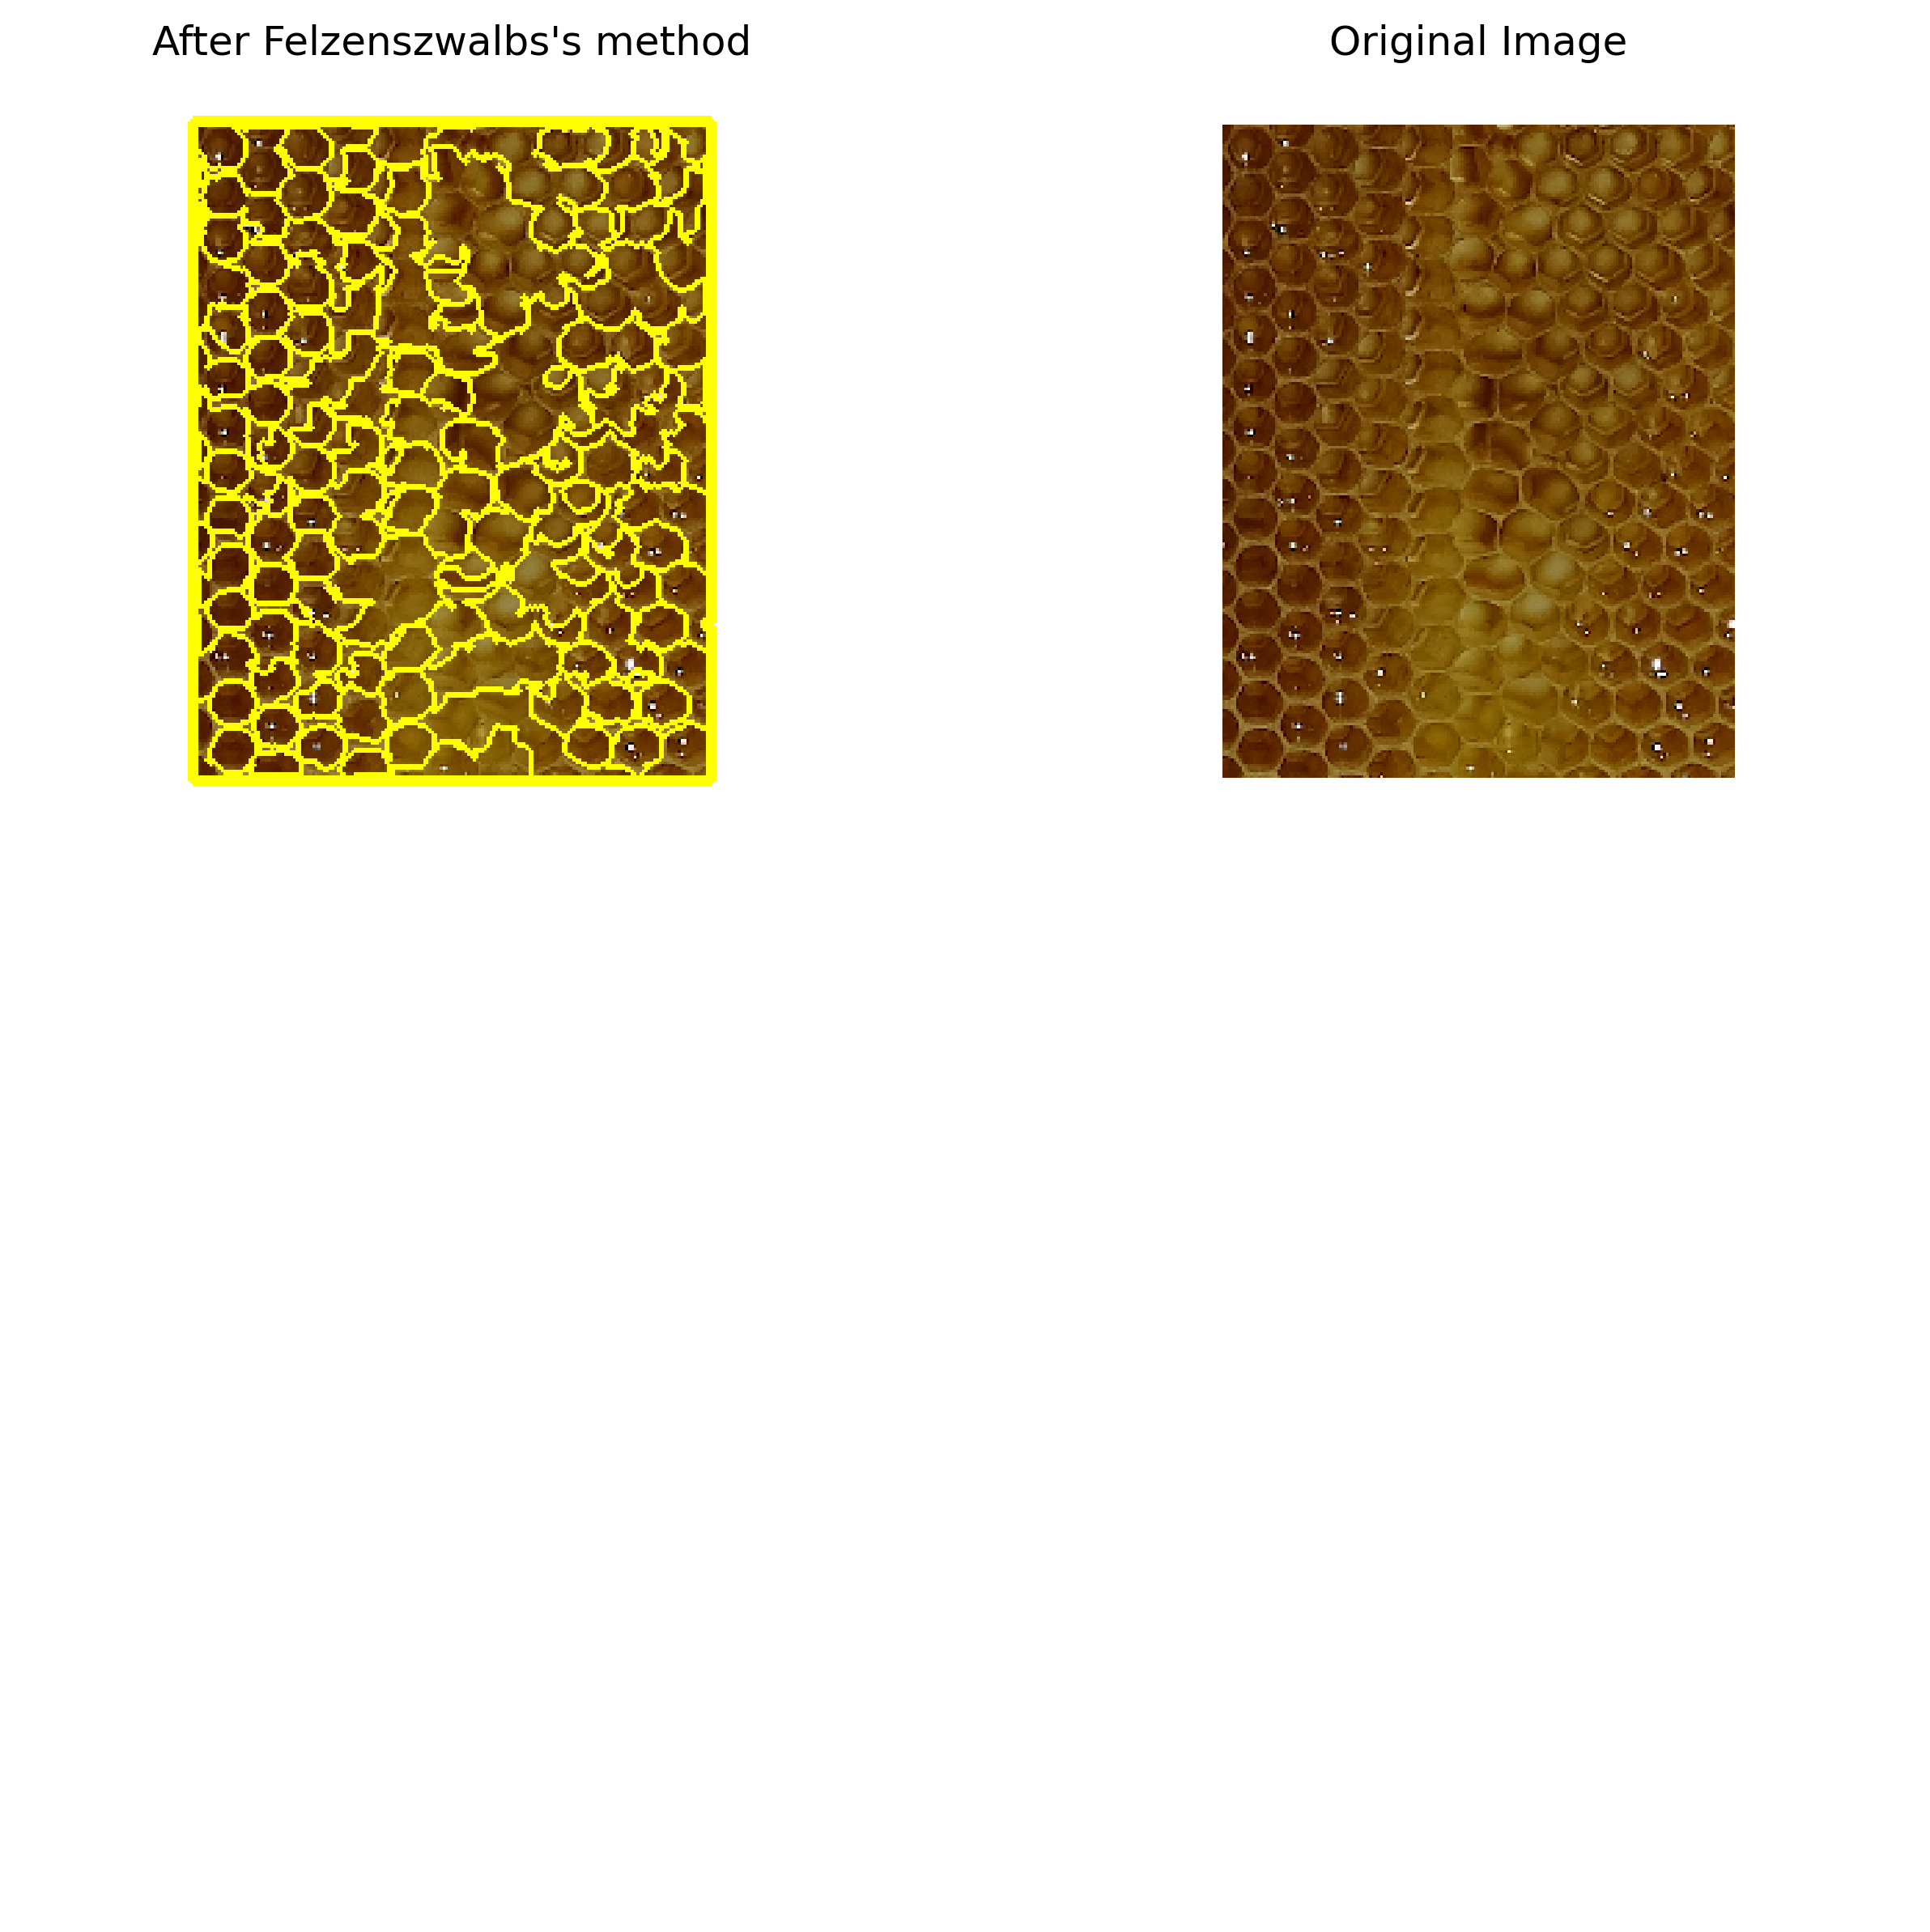

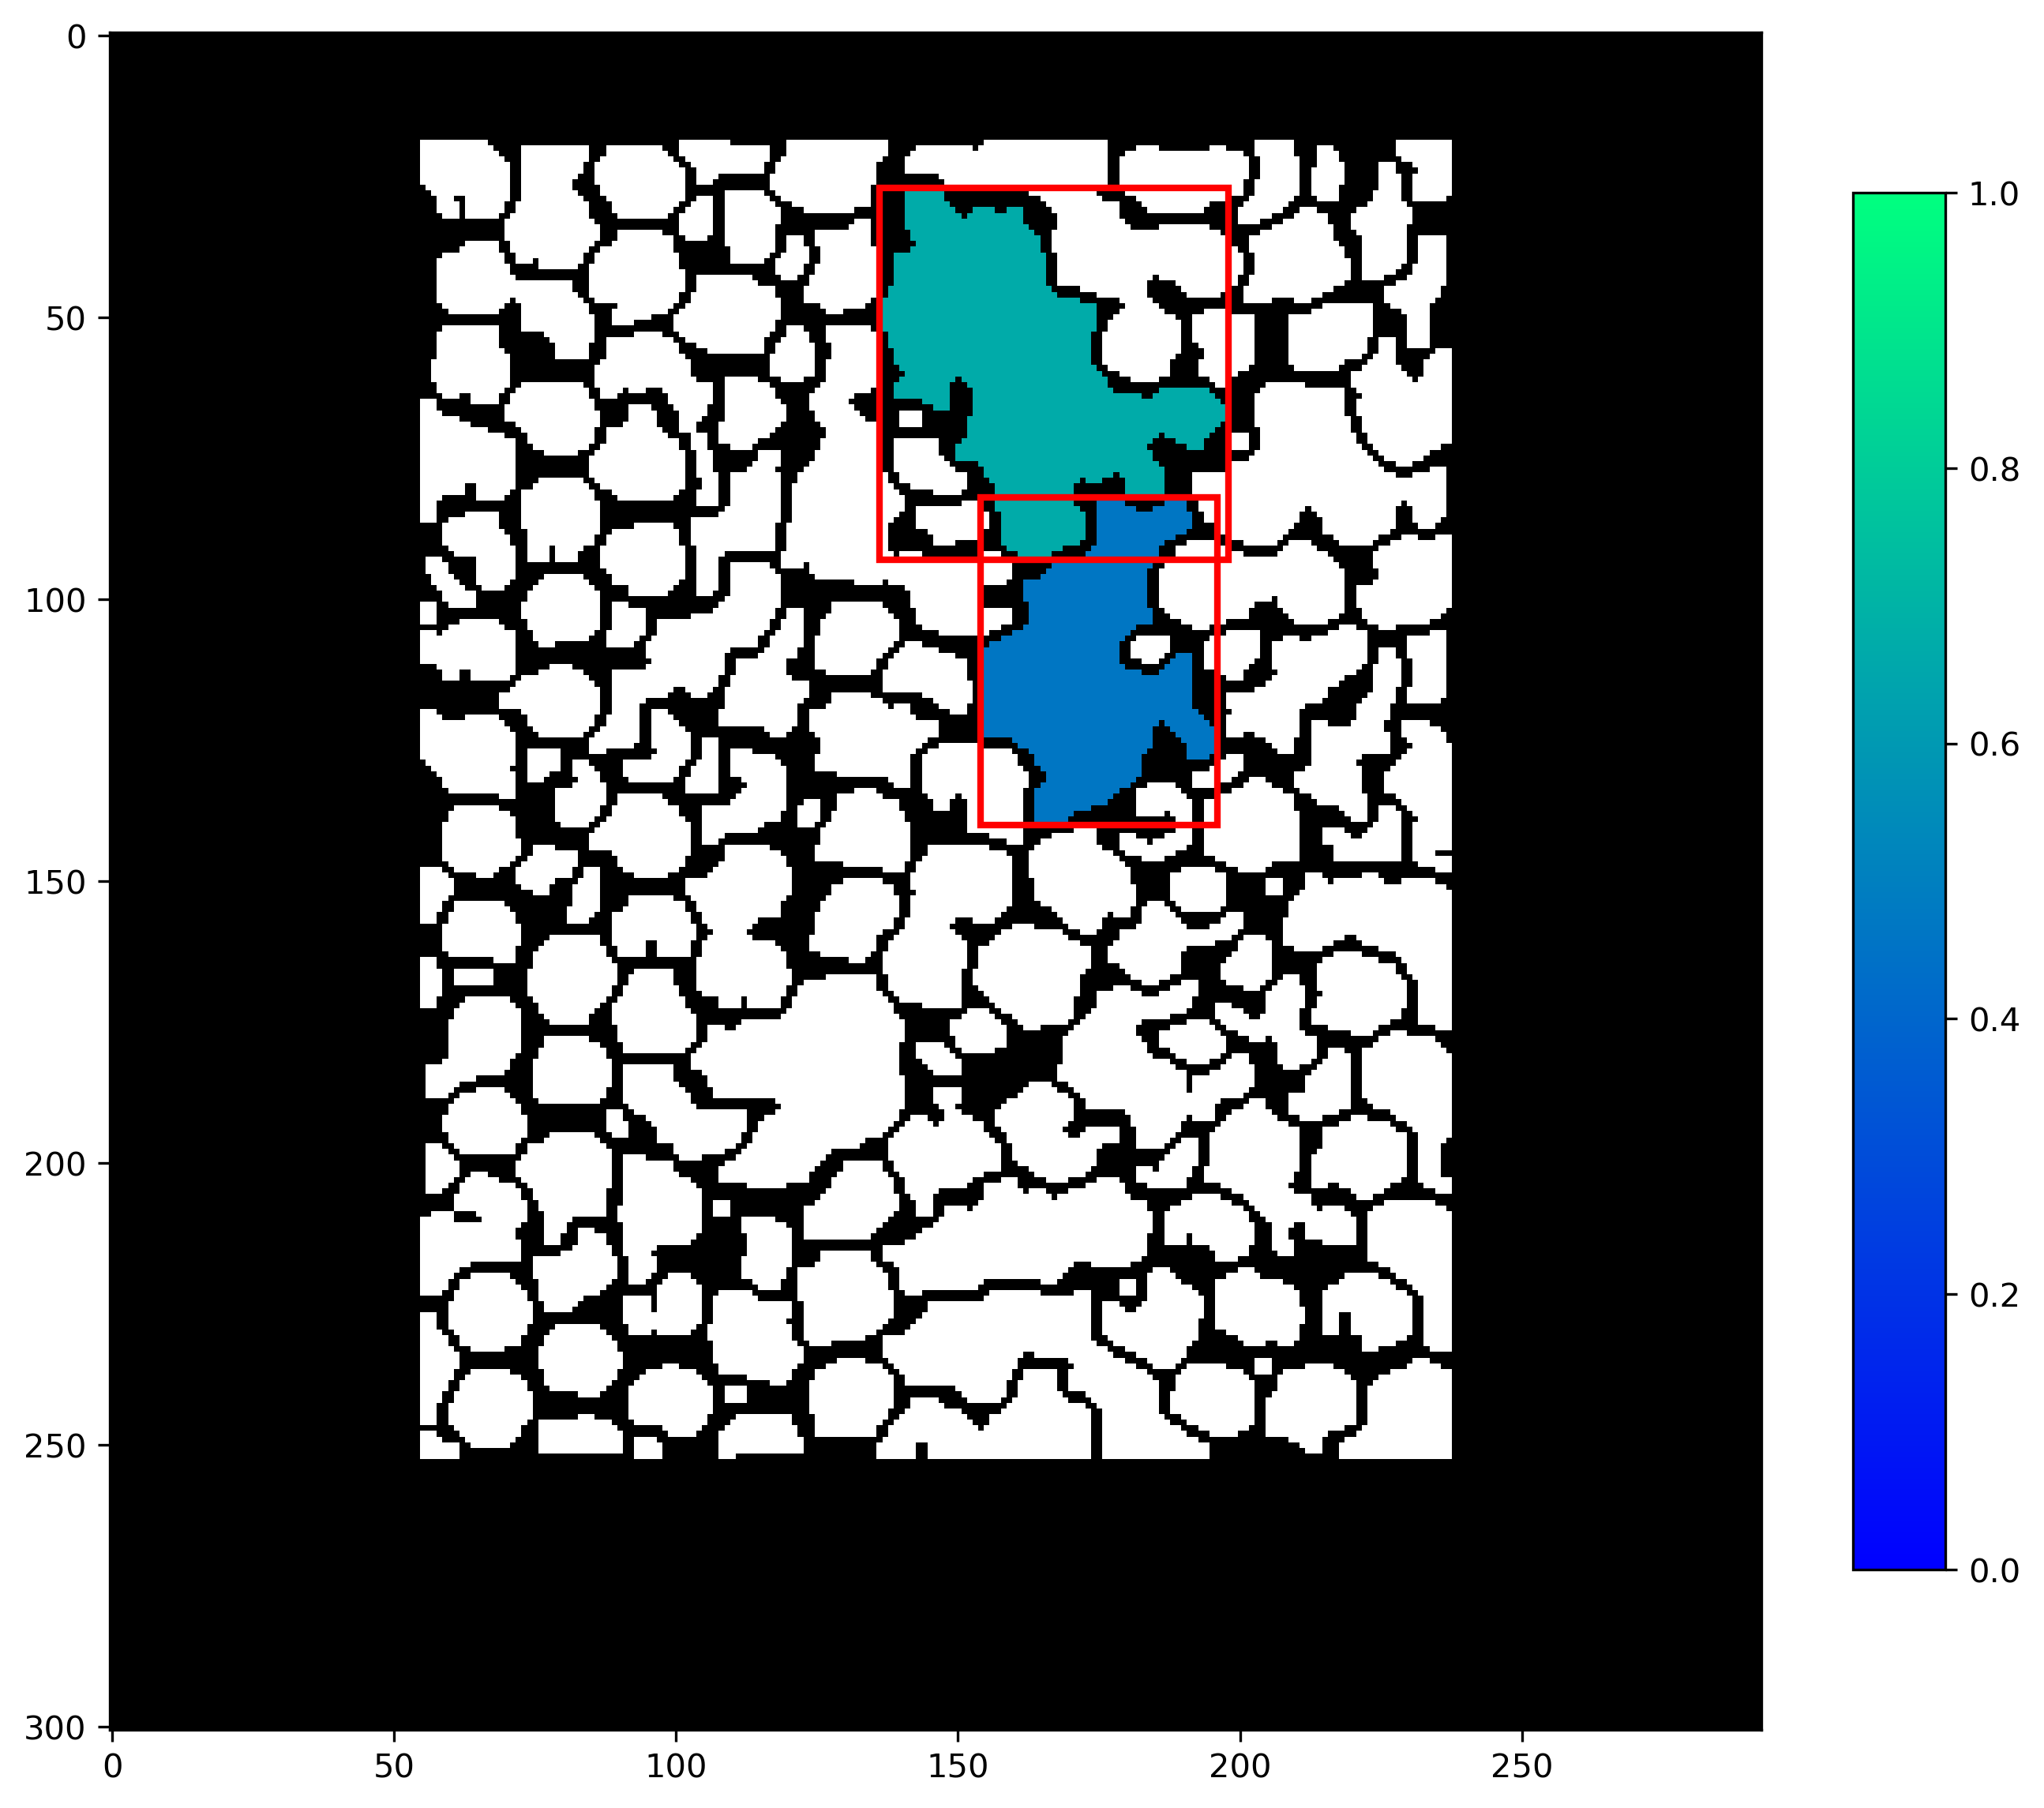

In [19]:
RGB_img = img_as_float(io.imread('{}/{}_crop{}.png'.format(plot_folder, file_name, crop_code)))

d, labeled_img , overlay_img, centroids = find_components(RGB_img, 1000.0, 2800.0)
print (centroids)

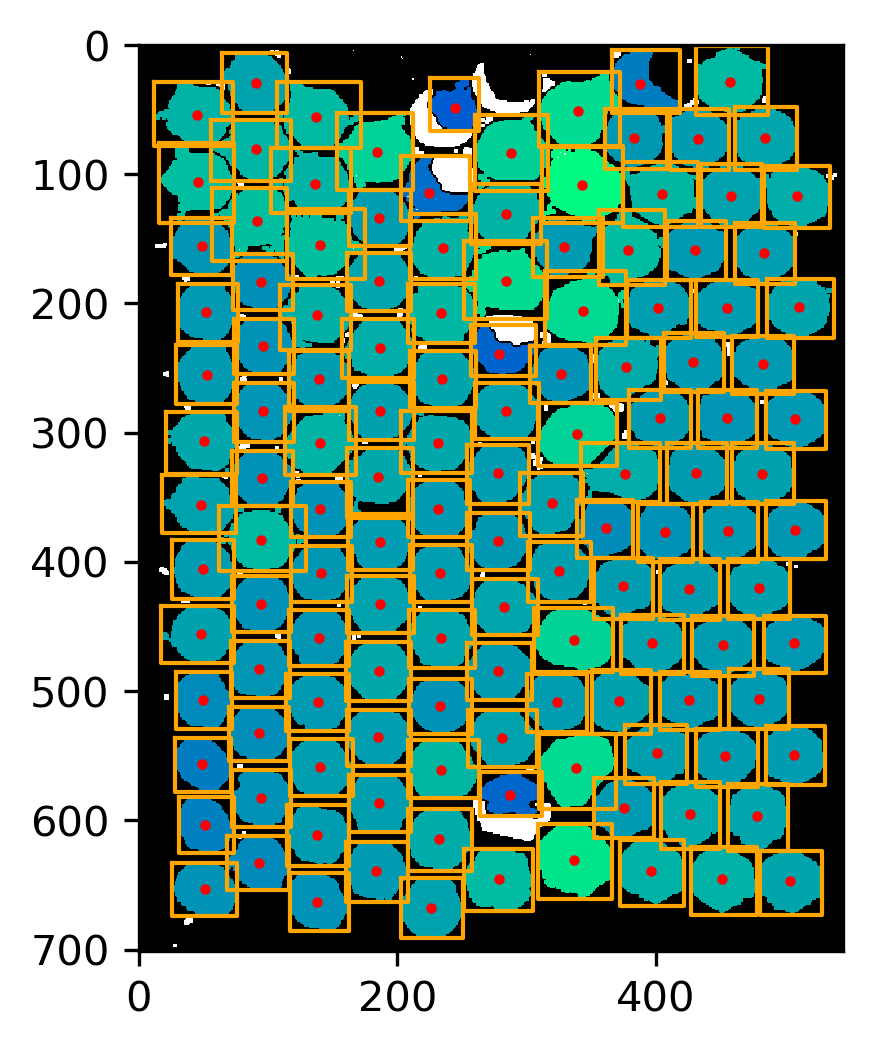

In [178]:
import math 

fig, ax = plt.subplots()
ax.imshow(overlay_img, cmap=plt.cm.gray)

for props in regionprops(labeled_img):
        
    
        if (props.area > 1000 and props.area < 2800): #these bounds should match the ones at the top function
    
            y0, x0 = props.centroid
            orientation = props.orientation

            x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
            y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
            x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
            y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

            #ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
            #ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)
            ax.plot(x0, y0, '.r', markersize=3)

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax.plot(bx, by, '-', color = 'orange', linewidth=1)

ax.axis((0, d[-2], d[-3], 0))
plt. savefig ('{}/{}_crop{}_centeroids.png'.format(plot_folder, file_name, crop_code))

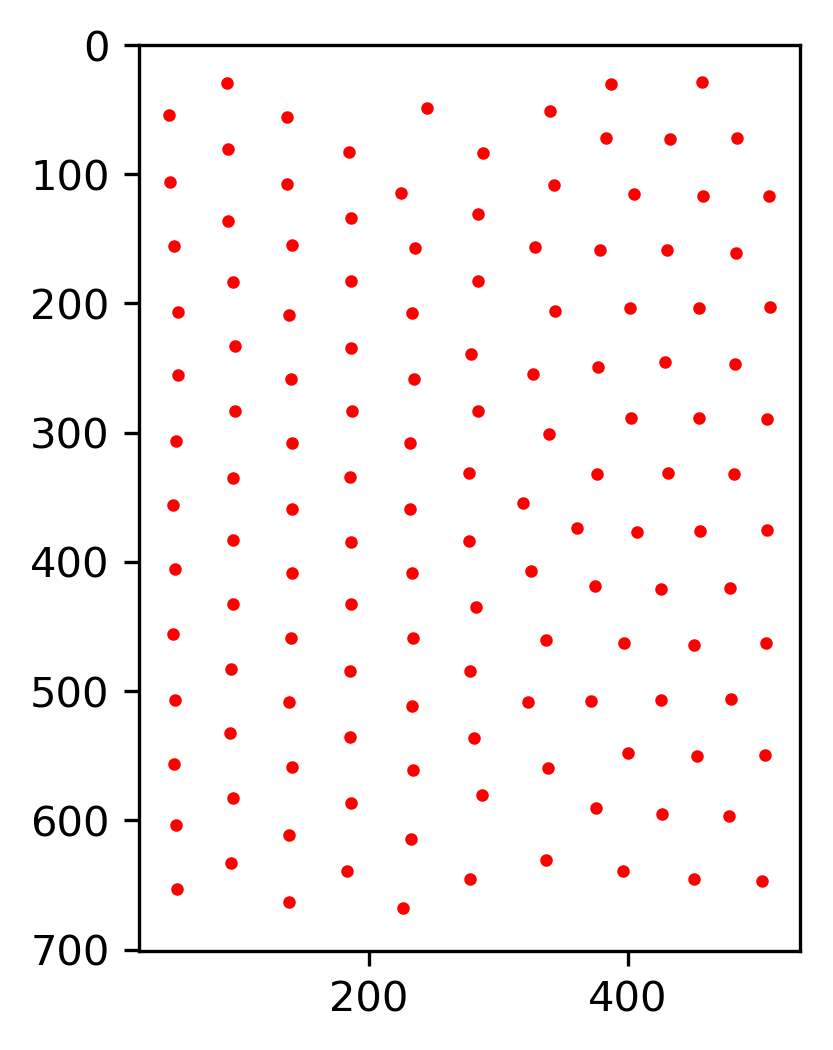

In [173]:
points = zip()

points_list = list(points)

fig, ax = plt.subplots()

ys = [x[0] for x in centroids]
xs = [x[1] for x in centroids]
#print ('xs =', xs)
#print ('ys =', ys)

points = zip(xs, ys)

points_list = list(points)

ax.plot (xs, ys, '.r', markersize = 4)
ax.set_aspect('equal')
ax.set_ylim (d[-3], 0)
plt.savefig ('{}/{}_crop{}_pointcloud.png'.format(plot_folder, file_name, crop_code))

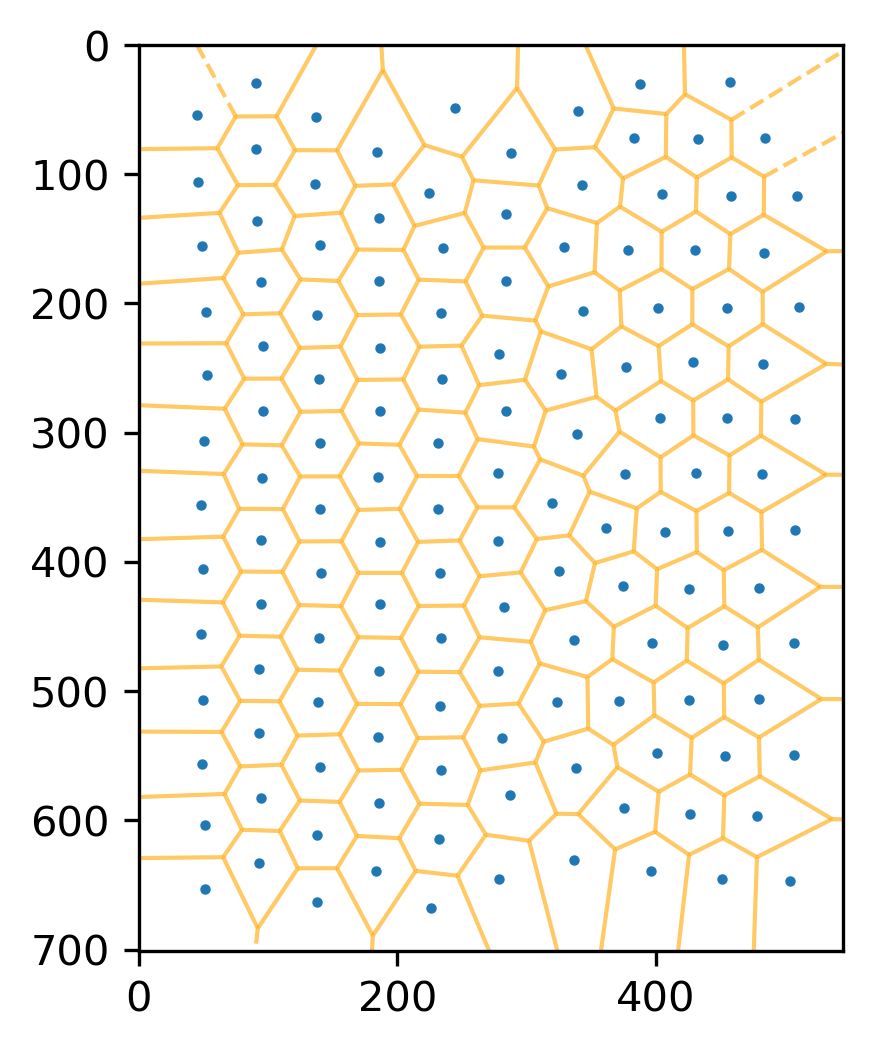

In [174]:
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(points_list)
fig, ax = plt.subplots()

fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                      line_width=1, line_alpha=0.6, point_size=3, ax=ax)
ax.set_xlim(0,d[-2])
ax.set_ylim (d[-3], 0)
ax.set_aspect('equal')

plt.savefig ('/Users/golnargharoonifard/Desktop/Bees/BeeCombExperiments/Images/1A/1A_crop1_vor.png')

In [175]:
#print(vor.regions)

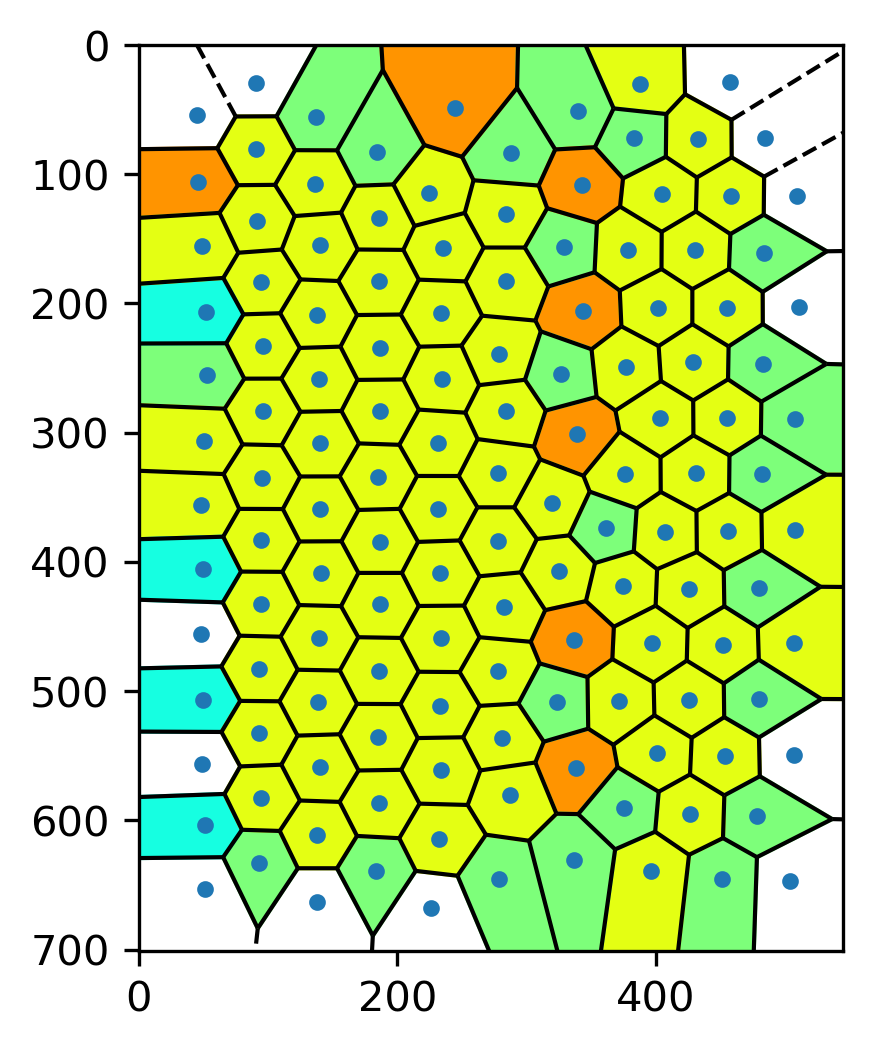

In [176]:

#colorize the Voronoi diagram based on the number of sides/neighbors of each cell

norm = mpl.colors.Normalize(vmin=1, vmax=8, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.jet)
bounds = [1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots()

vor = Voronoi(points_list)
vd = voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1, ax=ax)

for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        #print (len(region))
        vor_diag = ax.fill(*zip(*polygon), color=mapper.to_rgba(len(region)))
        
#mapper_list = [mapper.to_rgba(i) for i in vor.regions]
#print (mapper_list)


#ax.plot(points_list[0], points_list[1], 'ko', markersize = 1)
ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
#plt.ylim( vor.max_bound[1] + 0.1, vor.min_bound[1] - 0.1)
ax.set_aspect('equal')
#ax.axis ('off')
ax.set_ylim (d[-3], 0)
ax.set_xlim (0, d[-2])



plt.savefig ('{}/{}_crop{}_VorColorized.png'.format(plot_folder, file_name, crop_code))


('original image size:', 1089, 1402)


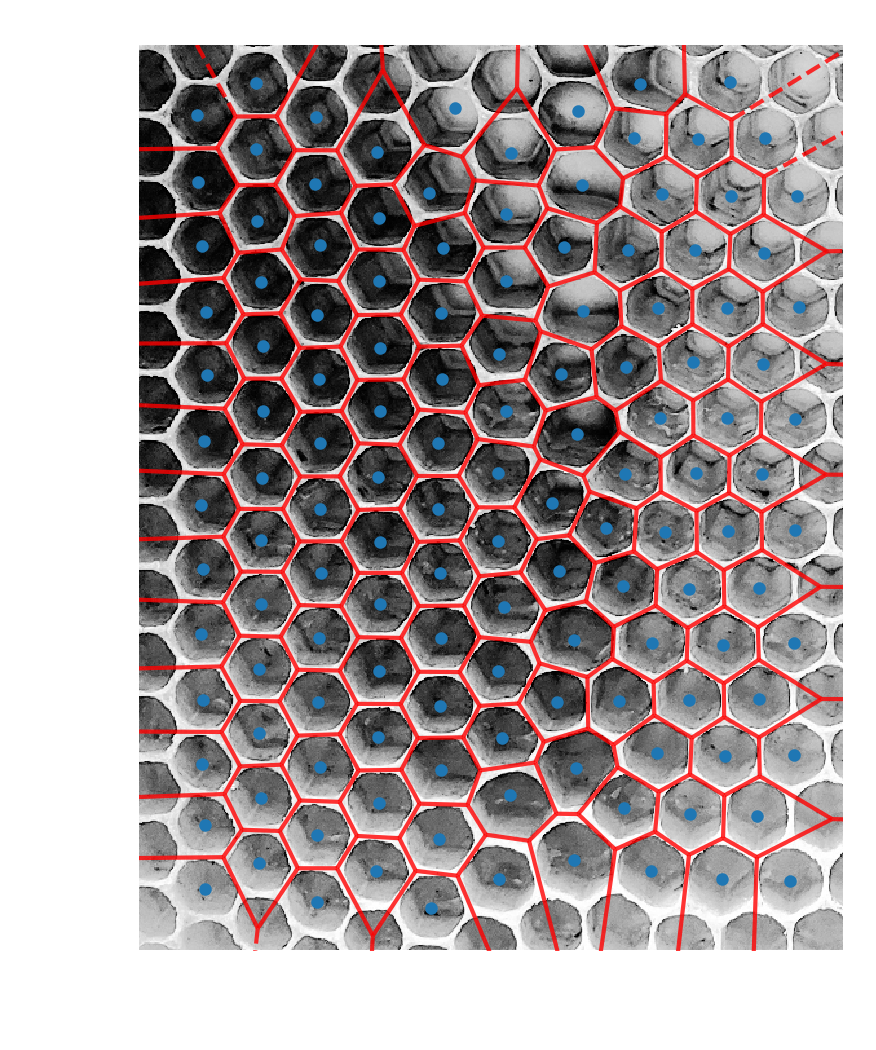

In [177]:
background_file = '{}/{}_crop{}_equalized.jpg'.format(plot_folder, file_name, crop_code)
im = Image.open(background_file)  
w, h = im.size
print('original image size:', w, h)
newsize = (d[-2], d[-3]) 
new_im = im.resize(newsize)

#img = plt.imread(img_file)
#plt.plot (img)

points = np.array(points_list)

vor = Voronoi(points)

voronoi_plot_2d(vor, show_vertices=False, line_colors='red',
                line_width=1, line_alpha=0.8, point_size=4)
plt.ylim (d[-3], 0)
plt.xlim (0, d[-2])
plt.axis('off')
#voronoi_plot_2d(vor, point_size=10, ax=ax)
#fig, ax = plt.subplots(1, 1 , figsize=(10, 10), sharex=True, sharey=True)
plt.imshow(new_im, interpolation='none')
plt.savefig ('{}/{}_crop{}_superimposed.png'.format(plot_folder, file_name, crop_code))

